In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pyleoclim as pyleo
import lipd
from palettable.colorbrewer.qualitative import Dark2_8
%matplotlib inline

In [2]:
# study sites
orbital_list=['Sanbao','Xiaobailong']

In [3]:
# latitudes of sites
lats={}
lats['Sanbao']=31.67
lats['Xiaobailong']=24.2

In [4]:
from os import listdir

def read_site(site):
    '''read all paleomeasurement data (age and d18O values) in LiPD files (speleothems)
    of the current folder
    Input:
    site: the name of the cave site. The function will read all files with the name of this site'''
    nrec = 0
    for f in listdir():
        if (site in f) and ('lpd' in f):
            print(f)
            #fr = lipd.readLipd(folder+'/'+f)
            fr = lipd.readLipd(f)
            tt = lipd.getMetadata(fr)
            cnrec = len(tt['paleoData']['paleo0']['measurementTable'])
            nrec = nrec + cnrec
            
    d18O = nrec*[0]
    age = nrec*[0]
    irec = 0
    
    for f in listdir():
        if (site in f) and ('lpd' in f):
            fr = lipd.readLipd(f)
            dd = lipd.getCsv(fr)
            tt = lipd.getMetadata(fr)
            
            #read lat,lon
            #geo[site]={}
            #geo[site]['lat']=tt['geo']['geometry']['coordinates'][1]
            #geo[site]['lon']=tt['geo']['geometry']['coordinates'][0]
    
            cnrec = len(tt['paleoData']['paleo0']['measurementTable'])
            kwds = tt['paleoData']['paleo0']['measurementTable']['paleo0measurement0']['columns'].keys()
            f0 = tt['paleoData']['paleo0']['measurementTable']['paleo0measurement0']['filename']
            fname = f0.replace('paleo0measurement0.csv','')
            for item in kwds:
                if 'd18' in item:
                    O18_name = item
                if ('Age' in item or 'age' in item) and not('Err' in item):
                    age_name = item
                    age_unit = tt['paleoData']['paleo0']['measurementTable']['paleo0measurement0']['columns'][item]['units']
            for i in range(0,cnrec):
                nstr = str(i)
                csvname = fname+"paleo0measurement"+nstr+".csv"
                #print(dd)
                d18O[irec] = dd[csvname][O18_name]['values']
                age[irec] = dd[csvname][age_name]['values']
                
                d18O[irec] = [np.nan if x=='nan' else x for x in d18O[irec]]
                age[irec] = [np.nan if x=='nan' else x for x in age[irec]]
                
                if age_unit == "kyBP" or age_unit == "kyrBP" or age_unit == "kaBP":
                    age[irec] = [1000*x for x in age[irec]]
                if age_unit == "AD":
                    age[irec] = [1950-x for x in age[irec]]
                irec = irec+1
    return d18O,age

In [5]:
# read and save all stalagmites in each site

d18O={}
age={}

for site in orbital_list:
    d18O_tmp, age_tmp = read_site(site)
    d18O[site]=d18O_tmp
    age[site]=age_tmp

Sanbao.lpd
Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Sanbao.lpd
Finished read: 1 record
Sanbao.Cheng.2016.lpd
Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Sanbao.Cheng.2016.lpd
Finished read: 1 record
Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Sanbao.lpd
Finished read: 1 record
Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Sanbao.Cheng.2016.lpd
Finished read: 1 record
Xiaobailong2015.lpd
Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Xiaobailong2015.lpd
Finished read: 1 record
Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Xiaobailong2015.lpd
Finished read: 1 record


In [6]:
def find_nan(x,age):
    '''Given an specific age range, find the age segments without d18O values
    Inputs:
    x: Lists of d18O values
    age: The age range (array) we want to make composite
    Outputs:
    nan1: The list of the beginning age points of the nan segments
    nan2: The list of the ending age points of nan segments'''
    nan1=[]
    nan2=[]
    if np.isnan(x[0]):
        nan1.append(age[0])
    for i in range(1,len(x)-1):
        if np.isnan(x[i]) and not(np.isnan(x[i-1])):
            nan1.append(x[i-1])
        if np.isnan(x[i]) and not(np.isnan(x[i+1])):
            nan2.append(x[i+1])
    if np.isnan(x[-1]):
        nan2.append(age[-1])
    return nan1,nan2

def plus_nan(a1,a2):
    '''Rules of adding two time series with nan values
    Inputs: a1,a2: two time series'''
    avg = np.zeros((len(a1)))
    for i in range(len(a1)):
        if np.isnan(a1[i]) and not(np.isnan(a2[i])):
            avg[i] = a2[i]
        if not(np.isnan(a1[i])) and np.isnan(a2[i]):
            avg[i] = a1[i]
        if not(np.isnan(a1[i])) and not(np.isnan(a2[i])):
            avg[i] = (a1[i]+a2[i])/2
        if np.isnan(a1[i]) and np.isnan(a2[i]):
            avg[i] = np.NAN
    return avg

def make_comp(site, start, end, interval):
    '''Calculate the composite of multiple d18O records'''
    age_new = np.arange(start,end,interval)
    d18O_new = np.arange(start,end,interval)
    d18O_new[:]=np.NAN
    for i in range(len(age[site])):
        f = interpolate.interp1d(age[site][i],d18O[site][i],bounds_error=False)
        ynew = f(age_new)
        
        nan1,nan2 = find_nan(age[site][i],age_new)
        nnan = len(nan1)
        for j in range(nnan):
            if nan1[j]>nan2[j]:
                nan1[j],nan2[j]=nan2[j],nan1[j]
            for k in range(int(nan1[j]/interval),int(nan2[j]/interval)):
                if k<=end/interval:
                    ynew[k] = np.NAN
        d18O_new = plus_nan(d18O_new,ynew)
    return age_new, d18O_new

In [7]:
from scipy import interpolate

def quick_interpolate(age, d18o, start, end, interval):
    '''Quckly interpolate a d18O time series to a given age range (array)'''
    age_new = np.arange(start,end,interval)
    d18O_new = np.arange(start,end,interval)
    d18O_new[:]=np.NAN
    
    f = interpolate.interp1d(age,d18o,bounds_error=False)
    ynew = f(age_new)
    return age_new, ynew

In [8]:
# Make and save the composite records
# from 400,000 BP to present
d18O_comp = {}
d18O_comp_std = {}
age_comp={}

for site in orbital_list:
    age_tmp, d18O_tmp = make_comp(site,0.,400001.0,100)
    d18O_comp[site]=d18O_tmp
    age_comp[site]=age_tmp

In [9]:
# Get insolation from the Python package climlab
from climlab import constants as const
from climlab.solar.insolation import daily_insolation
from climlab.solar.orbital import OrbitalTable

kyears = np.linspace(-400, 0, 4001 ) # thousands of years
# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=kyears)

# generate JJA insolation for all sites
insol={}
for site in orbital_list:
    lat=lats[site]
    days = np.linspace(0, const.days_per_year, 365)
    Q = daily_insolation([lat], days, orb)
    # Julian days 152-243 are JJA
    insol[site]= np.mean(Q[:,151:243], axis=1)

Opened data from /Users/hujun/miniconda3/envs/pyleoclim/lib/python3.6/site-packages/climlab/solar/orbital/data/orbit91.dat


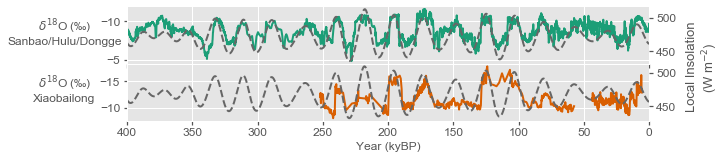

In [10]:
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 1, figsize=(10, 2.1),sharex=True)
fig.subplots_adjust(hspace=0.001)

i=0
for site in orbital_list:
    axs[i].plot(age_comp[site]/1000,d18O_comp[site],color=Dark2_8.mpl_colors[i])
    ax2 = axs[i].twinx()
    ax2.plot(np.linspace(400000, 0, 4001)/1000,insol[site],color = Dark2_8.mpl_colors[7],linestyle='dashed')
    if i==1:
        ax2.set_ylabel('Local Insolation\n'+r'(W m$^{-2}$)',rotation=90,fontsize=13)
    ax2.yaxis.set_label_coords(1.07, 0.95)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.grid(False)
    axs[i].set_xlabel('Year (kyBP)')
    if i==0:
        axs[i].set_ylabel(u'$\delta^{18}$O (\u2030)'+'\n'+'Sanbao/Hulu/Dongge',rotation=0,fontsize=12)
    else:
        axs[i].set_ylabel(u'$\delta^{18}$O (\u2030)'+'\n'+site,rotation=0,fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].set_xlim(0,400)
    #start, end = axs[i].get_ylim()
    #axs[i].yaxis.set_ticks(np.arange(start, end, 2))
    axs[i].invert_xaxis()
    axs[i].invert_yaxis()
    axs[i].yaxis.set_label_coords(-0.12, 0.3)
    i = i+1
plt.subplots_adjust(right=0.85)   
fig.savefig('Chinese_speleothems_orbital.pdf',dpi=300,bbox_inches='tight')